<a href="https://colab.research.google.com/github/brunoleme/Multilabel_and_Text_Classification/blob/main/Text_Multiclass_Classification_Music_Genre.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Dependencies**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install transformers

In [3]:
import pickle
import re
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import transformers
import torch.utils.data as tdata
import torch.optim as optim

from transformers import AutoModel, AutoTokenizer, BertForSequenceClassification

import tqdm

# **Data Prep**

In [4]:
with open('/content/drive/My Drive/AI_n_Music/axe.pkl', 'rb') as file:
    lyrics_axe = pickle.load(file)
with open('/content/drive/My Drive/AI_n_Music/funk.pkl', 'rb') as file:
    lyrics_funk = pickle.load(file)
with open('/content/drive/My Drive/AI_n_Music/mpb.pkl', 'rb') as file:
    lyrics_mpb = pickle.load(file)
with open('/content/drive/My Drive/AI_n_Music/pagode.pkl', 'rb') as file:
    lyrics_pagode = pickle.load(file)
with open('/content/drive/My Drive/AI_n_Music/samba.pkl', 'rb') as file:
    lyrics_samba = pickle.load(file)
with open('/content/drive/My Drive/AI_n_Music/sertanejo.pkl', 'rb') as file:
    lyrics_sertanejo = pickle.load(file)

## **Data Cleansing**

Consolidating in a unique list, as well as normalizing texts, and also cleaning html tags and special characters.

In [5]:
lyrics = []
for lyric in lyrics_axe:
  l = lyric[3].replace('</p>', '\n').replace('<p>', '\n').replace('<br>', '\n').replace('<br/>', '\n').replace('</br>', '\n').replace('\n\n\n', '\n\n').lower()
  l = re.sub(r'[^ \nA-Za-z0-9À-ÖØ-öø-ÿ/]+', '', l)
  lyrics.append(('axe', l))
for lyric in lyrics_funk:
  l = lyric[3].replace('</p>', '\n').replace('<p>', '\n').replace('<br>', '\n').replace('<br/>', '\n').replace('</br>', '\n').replace('\n\n\n', '\n\n').lower()
  l = re.sub(r'[^ \nA-Za-z0-9À-ÖØ-öø-ÿ/]+', '', l)
  lyrics.append(('funk', l))
for lyric in lyrics_mpb:
  l = lyric[3].replace('</p>', '\n').replace('<p>', '\n').replace('<br>', '\n').replace('<br/>', '\n').replace('</br>', '\n').replace('\n\n\n', '\n\n').lower()
  l = re.sub(r'[^ \nA-Za-z0-9À-ÖØ-öø-ÿ/]+', '', l)
  lyrics.append(('mpb', l))
for lyric in lyrics_pagode:
  l = lyric[3].replace('</p>', '\n').replace('<p>', '\n').replace('<br>', '\n').replace('<br/>', '\n').replace('</br>', '\n').replace('\n\n\n', '\n\n').lower()
  l = re.sub(r'[^ \nA-Za-z0-9À-ÖØ-öø-ÿ/]+', '', l)
  lyrics.append(('pagode', l))
for lyric in lyrics_samba:
  l = lyric[3].replace('</p>', '\n').replace('<p>', '\n').replace('<br>', '\n').replace('<br/>', '\n').replace('</br>', '\n').replace('\n\n\n', '\n\n').lower()
  l = re.sub(r'[^ \nA-Za-z0-9À-ÖØ-öø-ÿ/]+', '', l)
  lyrics.append(('samba', l))
for lyric in lyrics_sertanejo:
  l = lyric[3].replace('</p>', '\n').replace('<p>', '\n').replace('<br>', '\n').replace('<br/>', '\n').replace('</br>', '\n').replace('\n\n\n', '\n\n').lower()
  l = re.sub(r'[^ \nA-Za-z0-9À-ÖØ-öø-ÿ/]+', '', l)
  lyrics.append(('sertanejo', l))

In [6]:
#Creating lyrics index
data = []
for ix, lyric in enumerate(lyrics):
  if len(lyric[1].split()) == 0:
    continue
  data.append((ix, lyric[0], lyric[1])) #ix = index, lyric[0] = genre, lyric[1] = lyric

Possible genres.

In [7]:
np.unique([genre for _, genre, _ in data])

array(['axe', 'funk', 'mpb', 'pagode', 'samba', 'sertanejo'], dtype='<U9')

In [8]:
len(np.unique([genre for _, genre, _ in data]))

6

## **Data Patition**

In [9]:
data_train, data_valid = train_test_split(data, test_size=0.33, random_state=12345)

In [10]:
X_data_train = [lyric for _, _, lyric in data_train]
X_data_valid = [lyric for _, _, lyric in data_valid]
Y_data_train = [genre for _, genre, _ in data_train]
Y_data_valid = [genre for _, genre, _ in data_valid]

## **Target Label Encoding**

In [11]:
le = LabelEncoder()
Y_data_train_2 = le.fit_transform(Y_data_train)
Y_data_valid_2 = le.transform(Y_data_valid)

In [12]:
le.classes_

array(['axe', 'funk', 'mpb', 'pagode', 'samba', 'sertanejo'], dtype='<U9')

# **Modelling**

## **Model 1 - Bag of Words - TFIDF**

In [13]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
from nltk.corpus import stopwords

Using TFIDF as word vectorizer, ignoring portuguese stop words.

In [15]:
cv = TfidfVectorizer(stop_words=stopwords.words('portuguese')) #

In [16]:
X_data_train_2 = cv.fit_transform(X_data_train)
X_data_valid_2 = cv.transform(X_data_valid)

Defining domain for parameter tuning of ngram range, number of selected features (sfm__k), regularization penalty (l1 and l2) and strengh (C).

In [17]:
param_dist = dict(vectorizer__ngram_range = [(1,2), (1, 2), (1, 3)],
                  sfm__k=list(range(1, 10000)),
                  logistic__penalty=['l2', 'l1'],
                  logistic__C=uniform(loc=0, scale=4))

Defining a Pipeline to tune vectorizer, feasture selection (SelectKBest) and Logistic Regression, via Randomized Search.

In [18]:
# create pipeline with a scaler 
steps = []
steps.append(('vectorizer', cv))
steps.append(('sfm', SelectKBest(chi2)))
steps.append(('logistic', LogisticRegression(solver='liblinear', max_iter=200, random_state=12345)))
pipeline = Pipeline(steps)

# do search
search = RandomizedSearchCV(pipeline, param_distributions=param_dist)
search.fit(X_data_train, Y_data_train_2)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('vectorizer',
                                              TfidfVectorizer(analyzer='word',
                                                              binary=False,
                                                              decode_error='strict',
                                                              dtype=<class 'numpy.float64'>,
                                                              encoding='utf-8',
                                                              input='content',
                                                              lowercase=True,
                                                              max_df=1.0,
                                                              max_features=None,
                                                              min_df=1,
                                               

Best Parameters:

In [19]:
search.best_params_

{'logistic__C': 1.7533179964393022,
 'logistic__penalty': 'l2',
 'sfm__k': 9845,
 'vectorizer__ngram_range': (1, 2)}

In [20]:
results = []

In [21]:
print('Train Accuracy', accuracy_score(Y_data_train_2, search.predict(X_data_train)))
print('Valid Accuracy', accuracy_score(Y_data_valid_2, search.predict(X_data_valid)))

Train Accuracy 0.7866567089868061
Valid Accuracy 0.557070707070707


In [22]:
results.append(['Bag of Words - TFIDF',
      accuracy_score(Y_data_train_2, search.predict(X_data_train)),
      accuracy_score(Y_data_valid_2, search.predict(X_data_valid))
])

## **Model 2 - Continuous Skipgram - Pre-Trained**

Pre-trained Continuous Skipgram Word Embedding for Brazilian Portuguese, with dimensionality of 50, downloaded from http://www.nilc.icmc.usp.br/nilc/index.php/repositorio-de-word-embeddings-do-nilc

Creating a dictionary from pre-trained word embedding, with words as keys, and word vectors as values.

In [23]:
errors = []
embeddings_index = {}
f = open('/content/drive/My Drive/Data Master/skip_s50.txt')
for line in f:
    values = line.split()
    word = values[0] #first element is the word
    try:
      coefs = np.asarray(values[1:], dtype='float32') #second element and on is the word vector
    except:
      errors.append(line)
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 929595 word vectors.


In [24]:
print(len(embeddings_index))
print(len(errors))

929595
4


Creating matrix to sum all vectors of a document (lyric).

In [25]:
EMBEDDING_DIM = 50
errors_2 = []
nomatchs = []

X_train_matrix = np.zeros((len(X_data_train), EMBEDDING_DIM))
X_valid_matrix = np.zeros((len(X_data_valid), EMBEDDING_DIM))

Matching and summing all vector at matrix.

In [26]:
for i, x in enumerate(X_data_train):
  for w in x.split():
    embedding_vector = embeddings_index.get(w)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        try:
          X_train_matrix[i] += embedding_vector
        except:
          if [word, len(embedding_vector), embedding_vector] not in errors_2:
            errors_2.append([word, len(embedding_vector), embedding_vector])
    else:
      if word not in nomatchs:
        nomatchs.append(word)

In [27]:
for i, x in enumerate(X_data_valid):
  for w in x.split():
    embedding_vector = embeddings_index.get(w)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        try:
          X_valid_matrix[i] += embedding_vector
        except:
          if [word, len(embedding_vector), embedding_vector] not in errors_2:
            errors_2.append([word, len(embedding_vector), embedding_vector])
    else:
      if word not in nomatchs:
        nomatchs.append(word)

No match words at pre-trained word embedding.

In [28]:
errors_2

[['sentar-se-ia',
  51,
  array([ 0.      , -0.044833, -0.029979,  0.076439, -0.042523,  0.01291 ,
          0.067435, -0.121602,  0.040566, -0.040576, -0.031136, -0.014103,
         -0.10282 ,  0.110358,  0.057216,  0.069584,  0.004213,  0.003828,
          0.092477,  0.058995,  0.017613, -0.098365,  0.072649, -0.113315,
         -0.056719, -0.088877, -0.05544 , -0.003072, -0.028924, -0.15866 ,
         -0.033957,  0.090694,  0.016345, -0.018447,  0.135893, -0.024989,
          0.081702,  0.029871,  0.11887 ,  0.042139,  0.005366, -0.025255,
         -0.008088,  0.000869, -0.024878, -0.009964, -0.070131,  0.116469,
          0.130658,  0.023669, -0.087427], dtype=float32)]]

In [29]:
nomatchs

['sentar-se-ia']

In [30]:
X_train_matrix.shape

(4017, 50)

In [31]:
X_valid_matrix.shape

(1980, 50)

Defining domain for parameter tuning of regularization penalty (l1 and l2) and strengh (C).

In [32]:
param_dist = dict(logistic__C=uniform(loc=0, scale=4),
                  logistic__penalty=['l2', 'l1'])

Defining a Pipeline to tune Logistic Regression, via Randomized Search.

In [33]:
# create pipeline with a scaler 
steps = []
steps.append(('scaler', StandardScaler()))
steps.append(('logistic', LogisticRegression(solver='liblinear', max_iter=200, random_state=12345)))
pipeline = Pipeline(steps)

# do search
search = RandomizedSearchCV(pipeline, param_distributions=param_dist)
search.fit(X_train_matrix, Y_data_train_2)

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('scaler',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('logistic',
                                              LogisticRegression(C=1.0,
                                                                 class_weight=None,
                                                                 dual=False,
                                                                 fit_intercept=True,
                                                                 intercept_scaling=1,
                                                                 l1_ratio=None,
                                                                 max_iter=200,


In [34]:
print('Train Accuracy', accuracy_score(Y_data_train_2, search.predict(X_train_matrix)))
print('Valid Accuracy', accuracy_score(Y_data_valid_2, search.predict(X_valid_matrix)))

Train Accuracy 0.4625342295245208
Valid Accuracy 0.43333333333333335


In [35]:
results.append(['Skipgram - Pre-Trained',
      accuracy_score(Y_data_train_2, search.predict(X_train_matrix)),
      accuracy_score(Y_data_valid_2, search.predict(X_valid_matrix))
])

## **Model 3 - Continuous Skipgram - Task-Specific**

Trying to train an specific Continuous Skipgram model, with present lyrics corpus, through gensim package.

In [36]:
from gensim.models import Word2Vec

Training a Continuous Skipgram model with dimension size 50, context window size 5.

In [37]:
model = Word2Vec(sentences=[sentence.split() for sentence in X_data_train], size=50, window=5, min_count=1, workers=4, sg=1)

Creating matrix to sum all vectors of a document (lyric).

In [38]:
EMBEDDING_DIM = 50
errors_2 = []
nomatchs = []

X_train_matrix = np.zeros((len(X_data_train), EMBEDDING_DIM))
X_valid_matrix = np.zeros((len(X_data_valid), EMBEDDING_DIM))

Matching and summing all vector at matrix.

In [39]:
for i, x in enumerate(X_data_train):
  for w in x.split():
    if w in model.wv:
      embedding_vector = model.wv[w]
      try:
        X_train_matrix[i] += embedding_vector
      except:
        errors_2.append([word, len(embedding_vector), embedding_vector])
    else:
      nomatchs.append(word)

In [40]:
for i, x in enumerate(X_data_valid):
  for w in x.split():
    if w in model.wv:
      embedding_vector = model.wv[w]
      try:
        X_valid_matrix[i] += embedding_vector
      except:
        errors_2.append([word, len(embedding_vector), embedding_vector])
    else:
      nomatchs.append(word)

In [41]:
X_train_matrix.shape

(4017, 50)

In [42]:
X_valid_matrix.shape

(1980, 50)

Defining domain for parameter tuning of regularization penalty (l1 and l2) and strengh (C).

In [43]:
param_dist = dict(logistic__C=uniform(loc=0, scale=4),
                  logistic__penalty=['l2', 'l1'])

Defining a Pipeline to tune Logistic Regression, via Randomized Search.

In [44]:
# create pipeline with a scaler 
steps = []
steps.append(('scaler', StandardScaler()))
steps.append(('logistic', LogisticRegression(solver='liblinear', max_iter=200, random_state=12345)))
pipeline = Pipeline(steps)

# do search
search = RandomizedSearchCV(pipeline, param_distributions=param_dist)
search.fit(X_train_matrix, Y_data_train_2)

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('scaler',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('logistic',
                                              LogisticRegression(C=1.0,
                                                                 class_weight=None,
                                                                 dual=False,
                                                                 fit_intercept=True,
                                                                 intercept_scaling=1,
                                                                 l1_ratio=None,
                                                                 max_iter=200,


In [45]:
print('Train Accuracy', accuracy_score(Y_data_train_2, search.predict(X_train_matrix)))
print('Valid Accuracy', accuracy_score(Y_data_valid_2, search.predict(X_valid_matrix)))

Train Accuracy 0.5053522529250685
Valid Accuracy 0.48434343434343435


In [46]:
results.append(['Skipgram - Task-Specific',
      accuracy_score(Y_data_train_2, search.predict(X_train_matrix)),
      accuracy_score(Y_data_valid_2, search.predict(X_valid_matrix))
])

## **Model 4 - BERT**

Specifying device (CUDA if available, CPU otherwise).

In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### **Importing Pre-Trained Model**

Pre-trained BERT model for Brazilian Portuguese (BERTimbau), downloaded from https://github.com/neuralmind-ai/portuguese-bert

In [48]:
bert_tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased', )
#bert_model = BertForSequenceClassification.from_pretrained('neuralmind/bert-large-portuguese-cased').to(device)
bert_model = BertForSequenceClassification.from_pretrained(
    'neuralmind/bert-base-portuguese-cased', # Use the 12-layer BERT model, with an uncased vocab. 
    num_labels = 6, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.  
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

### **Data Preparation**

Tokenizing all sentences with BERT Model, adding initial [CLS] token and [PAD] tokens at the sentence ending, and also making sentence truncation whenever necessary. The resultant sentence list will be in tensor format.

In [49]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids_train = []
attention_masks_train = []

# For every sentence...
for lyric in tqdm.notebook.tqdm(data_train):
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    sent = lyric[2]
    encoded_dict = bert_tokenizer.encode_plus(
                        sent, # Sentence A to encode.                 
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 512,           # Pad & truncate all sentences.
                        padding='max_length',
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                        truncation=True
                   )
    
    # Add the encoded sentence to the list.    
    input_ids_train.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks_train.append(encoded_dict['attention_mask'])


# Convert the lists into tensors.
input_ids_train = torch.cat(input_ids_train, dim=0)
attention_masks_train = torch.cat(attention_masks_train, dim=0)

In [50]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids_valid = []
attention_masks_valid = []

# For every sentence...
for lyric in tqdm.notebook.tqdm(data_valid):
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    sent = lyric[2]
    encoded_dict = bert_tokenizer.encode_plus(
                        sent, # Sentence to encode.                     
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 512,           # Pad & truncate all sentences.
                        padding='max_length',
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                        truncation=True
                   )
    
    # Add the encoded sentence to the list.    
    input_ids_valid.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks_valid.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids_valid = torch.cat(input_ids_valid, dim=0)
attention_masks_valid = torch.cat(attention_masks_valid, dim=0)

Converting labels do tensors.

In [51]:
labels_train = torch.tensor(Y_data_train_2)
labels_valid = torch.tensor(Y_data_valid_2)

In [52]:
input_ids_train.shape

torch.Size([4017, 512])

In [53]:
labels_train.shape

torch.Size([4017])

Creating tensor data sets.

In [54]:
from torch.utils.data import TensorDataset

In [55]:
train_dataset = TensorDataset(input_ids_train, attention_masks_train, labels_train)
valid_dataset = TensorDataset(input_ids_valid, attention_masks_valid, labels_valid)

In [56]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 12

# Create the DataLoaders for our training and validation sets.
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly, to train in a random order.
            batch_size = batch_size # Trains with this batch size.
        )

validation_dataloader = DataLoader(
            valid_dataset, # The validation samples.
            sampler = SequentialSampler(valid_dataset), # For validation, it doesn't matter the order, so we'll read batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

### **Fine Tuning - BertForSequenceClassification**

In [57]:
from transformers import AdamW, BertConfig
# Tell pytorch to run this model on the GPU.
bert_model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [58]:
optimizer = AdamW(bert_model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [59]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs].
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [60]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [61]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [62]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# training and validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss and accuracy for this epoch.
    total_train_loss = 0
    total_train_accuracy = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    bert_model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        bert_model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        result = bert_model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        
        loss, logits = result.loss, result.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(bert_model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

        # Move logits and labels to CPU
        logits_train = logits.detach().cpu().numpy()
        label_ids_train = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of train sentences, and
        # accumulate it over all batches.
        total_train_accuracy += flat_accuracy(logits_train, label_ids_train)

      
    # Report the final accuracy for this validation run.
    avg_train_accuracy = total_train_accuracy / len(train_dataloader)

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Training accuracy: {0:.2f}".format(avg_train_accuracy))
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    bert_model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    validation_results = []

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            results_val = bert_model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
            loss_val, logits_val = results_val.loss, results_val.logits

            validation_results.append(logits_val)
            
        # Accumulate the validation loss.
        total_eval_loss += loss_val.item()

        # Move logits and labels to CPU
        logits_val = logits_val.detach().cpu().numpy()
        label_ids_val = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits_val, label_ids_val)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Validation accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Training Accur.': avg_train_accuracy,
            'Valid Loss': avg_val_loss,
            'Valid Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    335.    Elapsed: 0:00:46.
  Batch    80  of    335.    Elapsed: 0:01:37.
  Batch   120  of    335.    Elapsed: 0:02:26.
  Batch   160  of    335.    Elapsed: 0:03:15.
  Batch   200  of    335.    Elapsed: 0:04:05.
  Batch   240  of    335.    Elapsed: 0:04:55.
  Batch   280  of    335.    Elapsed: 0:05:44.
  Batch   320  of    335.    Elapsed: 0:06:34.

  Training accuracy: 0.47
  Average training loss: 1.35
  Training epcoh took: 0:06:52

Running Validation...
  Validation accuracy: 0.57
  Validation Loss: 1.14
  Validation took: 0:01:15

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    335.    Elapsed: 0:00:50.
  Batch    80  of    335.    Elapsed: 0:01:39.
  Batch   120  of    335.    Elapsed: 0:02:29.
  Batch   160  of    335.    Elapsed: 0:03:19.
  Batch   200  of    335.    Elapsed: 0:04:08.
  Batch   240  of    335.    Elapsed: 0:04:58.
  Batch   280  of    335.    Elapsed: 0:05:47.
  Batch   320  of  

In [63]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Training Accur.,Valid Loss,Valid Accur.,Training Time,Validation Time
epoch,,,,,,
1,1.35,0.47,1.14,0.57,0:06:52,0:01:15
2,0.97,0.65,1.01,0.63,0:06:55,0:01:15
3,0.71,0.76,1.05,0.64,0:06:55,0:01:15
4,0.52,0.84,1.06,0.64,0:06:55,0:01:15


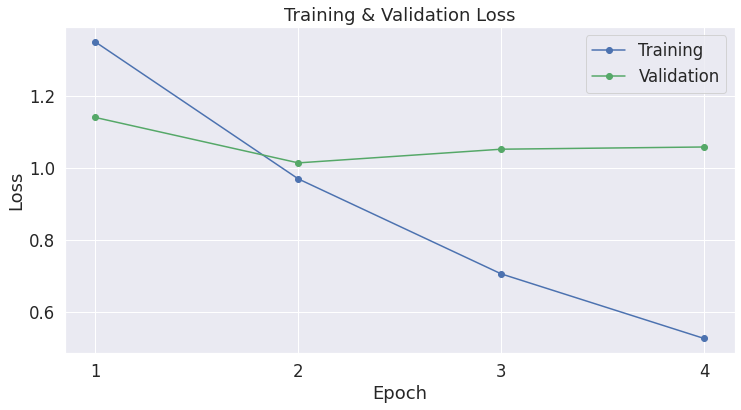

In [64]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [65]:
training_stats[-1]['Training Accur.']

0.840961857379768

In [66]:
training_stats[-1]['Valid Accur.']

0.6449494949494953

In [67]:
print('Train Accuracy', training_stats[-1]['Training Accur.'])
print('Valid Accuracy', training_stats[-1]['Valid Accur.'])

Train Accuracy 0.840961857379768
Valid Accuracy 0.6449494949494953


In [68]:
results.append(['BERT - Pre-Trained (Bertimbau)',
      training_stats[-1]['Training Accur.'],
      training_stats[-1]['Valid Accur.']
])

# **Results**

## **AUC Comparision**

In [69]:
pd.DataFrame(results, columns=['Model', 'Training Accur.', 'Valid Accur.'])

,Model,Training Accur.,Valid Accur.
0,Bag of Words - TFIDF,0.79,0.56
1,Skipgram - Pre-Trained,0.46,0.43
2,Skipgram - Task-Specific,0.51,0.48
3,BERT - Pre-Trained (Bertimbau),0.84,0.64


## **Confusion Matrix - Best Model**

In [70]:
val_pred_labels = np.array([])
for b in validation_results:
  val_pred_labels = np.append(val_pred_labels, np.argmax(b.detach().cpu().numpy(), axis=1).flatten())

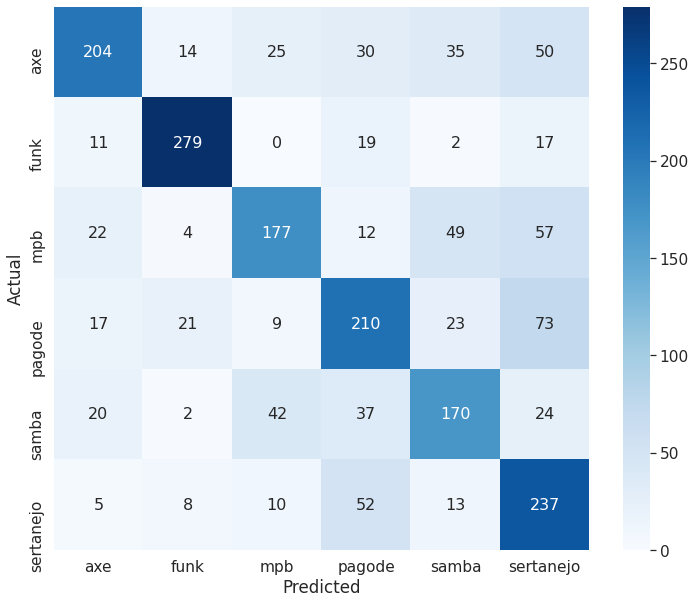

In [71]:
from sklearn.metrics import confusion_matrix

y_true = labels_valid.detach().cpu().numpy()
y_pred = val_pred_labels
data = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(data, columns=le.classes_, index = le.classes_)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (12,10))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True, fmt='g', annot_kws={"size": 16})# font size

As seen above, the model is making some confusion between MPB and Samba styles, styles that sometimes are very similar, as well as Pagode and Sertanejo, the artists from these two genres usually performes musics from each other genre.

## **Precision, Recall and F1 Score - Best Model**

In [72]:
precision_recall_results = []
for genre in le.classes_:
  precision = df_cm.loc[genre, genre] / df_cm.loc[:, genre].sum()
  recall = df_cm.loc[genre, genre] / df_cm.loc[genre, :].sum()
  f1_score = (2*(precision * recall)) / (precision + recall)
  precision_recall_results.append([precision, recall, f1_score])
df_precision_recall_results = pd.DataFrame(precision_recall_results, columns=['precision', 'recall', 'f1_score'], index=le.classes_)

In [73]:
df_precision_recall_results

,precision,recall,f1_score
axe,0.73,0.57,0.64
funk,0.85,0.85,0.85
mpb,0.67,0.55,0.61
pagode,0.58,0.59,0.59
samba,0.58,0.58,0.58
sertanejo,0.52,0.73,0.61
